In [5]:
# !pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\amine\AppData\Local\Temp\pip-req-build-eao3e_sx'



  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\amine\appdata\local\temp\pip-req-build-eao3e_sx
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 953.8/953.8 kB 2.2 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7841 sha256=60abec40826739dd498512d098a3df94a8cbe46f01aad54c865f00414a923209
  Stored in directory: C:\Users\amine\AppData\Local\Temp\pip-ephem-wheel-cache-djopg0sh\wheels\53\55\8b\d8f1e535dd21c6e20c2c776aa8cb0ea455bec4b44d11c22f49
Successfully built text-flappy-bird-gym


In [8]:
import numpy     as np
import gymnasium as gym
import text_flappy_bird_gym
from   tqdm      import tqdm
import matplotlib.pyplot as plt
from   collections import defaultdict
from   mpl_toolkits.mplot3d import Axes3D
from   IPython.display import clear_output
from   mpl_toolkits.axes_grid1 import make_axes_locatable
import os, sys
import time
import pickle 


import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

### Test Random Policy

In [104]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        # Render the game
        clear_output(wait=True)
        sys.stdout.write(env.render())
        time.sleep(0.4) 

        # If player is dead break
        if done:
            break

env.close()



Text Flappy Bird!
Score: 1
----------------------
[      |         |   ]
[      |         |   ]
[     *|         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                |   ]
[                    ]
[                    ]
[                    ]
[      |             ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=0,dy=-6)


#### Monte Carlo Control as used in LAB4 for Blackjack game

In [24]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state,_ = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, info,_= env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = [epsilon/nA]*nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] += 1-epsilon
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q
        Q[state][actions[i]]=old_Q[state][actions[i]]+alpha*(np.sum(discounts[:len(rewards[i:])] *rewards[i:])-old_Q[state][actions[i]]) 
    return Q

In [25]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode =generate_episode_from_Q(env, Q, epsilon, nA) 
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

#### Train the Monte Carlo control policy

In [26]:
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

In [28]:
Q_idle = {}
Q_flap = {}
for key, value in Q.items():
    Q_idle[key] = value[0]
    Q_flap[key] = value[1]
with open('MC_Action_value_function_idle.pkl', 'wb') as f:
    pickle.dump(Q_idle, f)
with open('MC_Action_value_function_flap.pkl', 'wb') as f:
    pickle.dump(Q_flap, f)
with open('MC_Policy.pkl', 'wb') as f:
    pickle.dump(policy, f)

In [29]:
V = dict((k,np.max(v)) for k, v in Q.items())

Plot State Q_values

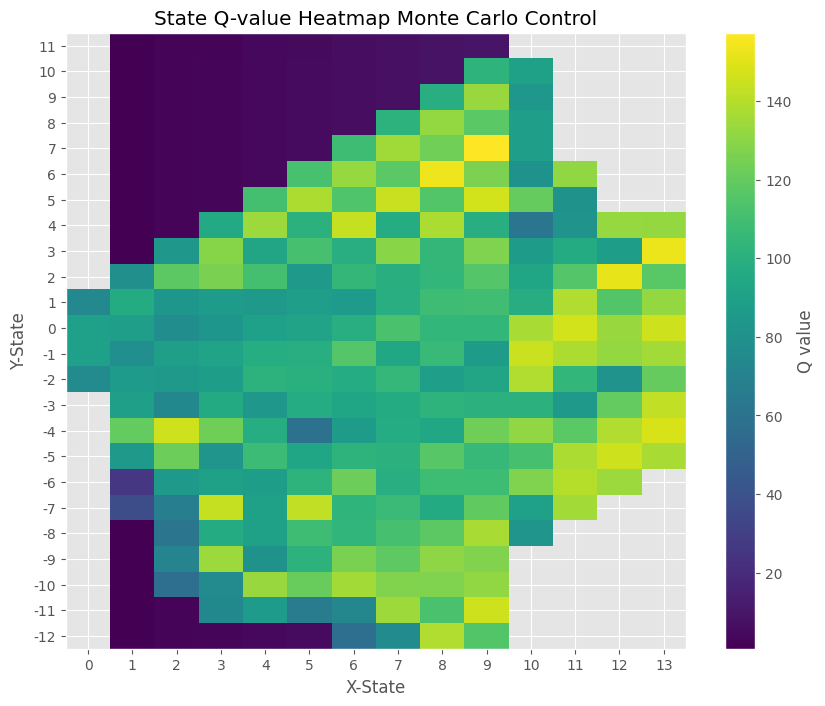

In [137]:
state_x = [key[0] for key in V.keys()]
state_y = [key[1] for key in V.keys()]
q_values = [val for val in V.values()]

# Find the range for the states to set up the axes of the heatmap
max_x = max(state_x)
min_x = min(state_x)
max_y = max(state_y)
min_y = min(state_y)

# Set up the grid for the heatmap
grid_x, grid_y = np.meshgrid(range(min_x, max_x + 1), range(min_y, max_y + 1))

# Initialize a grid for Q values
q_value_grid = np.full(grid_x.shape, np.nan)

# Populate the grid with Q values
for x, y, q in zip(state_x, state_y, q_values):
    q_value_grid[y - min_y, x - min_x] = q  # Notice the reversal of indices to match the meshgrid

# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.pcolormesh(grid_x, grid_y, q_value_grid, cmap='viridis', shading='auto')
plt.colorbar(c, label='Q value')

# Set the ticks for the states
plt.xticks(ticks=np.arange(min_x, max_x+1), labels=np.arange(min_x, max_x+1))
plt.yticks(ticks=np.arange(min_y, max_y+1), labels=np.arange(min_y, max_y+1))

plt.xlabel('X-State')
plt.ylabel('Y-State')
plt.title('State Q-value Heatmap Monte Carlo Control')
plt.show()


Let's play with MC 

In [102]:
obs,info = env.reset()
while True: 
    action = policy[obs]
    obs, reward, done, _, info = env.step(action)
    clear_output(wait=True)
    sys.stdout.write(env.render())
    time.sleep(0.4) 
    if done:
        break

Text Flappy Bird!
Score: 8
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[            |       ]
[            |       ]
[            |       ]
[                    ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |         |       ]
[  |         |       ]
[  |  *      |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=6,dy=5)


### Test The Perforamance of the Agent

In [145]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
num_episodes = 5000
score_list = []
for episode in range(num_episodes):
    obs,info = env.reset()
    while True: 
        action = policy[obs]
        obs, reward, done, _, info = env.step(action)
        if done:
            break
    score_list.append(info['score'])

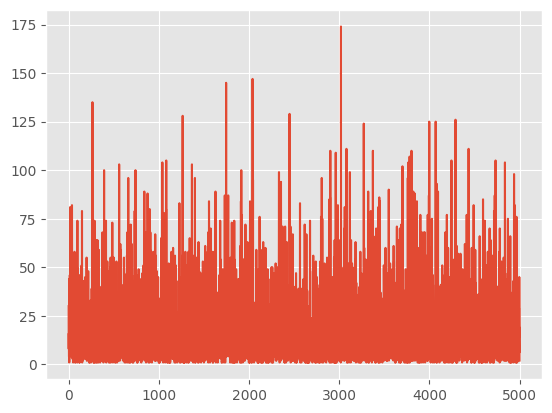

In [146]:
plt.plot([i for i in range(5000)],score_list)

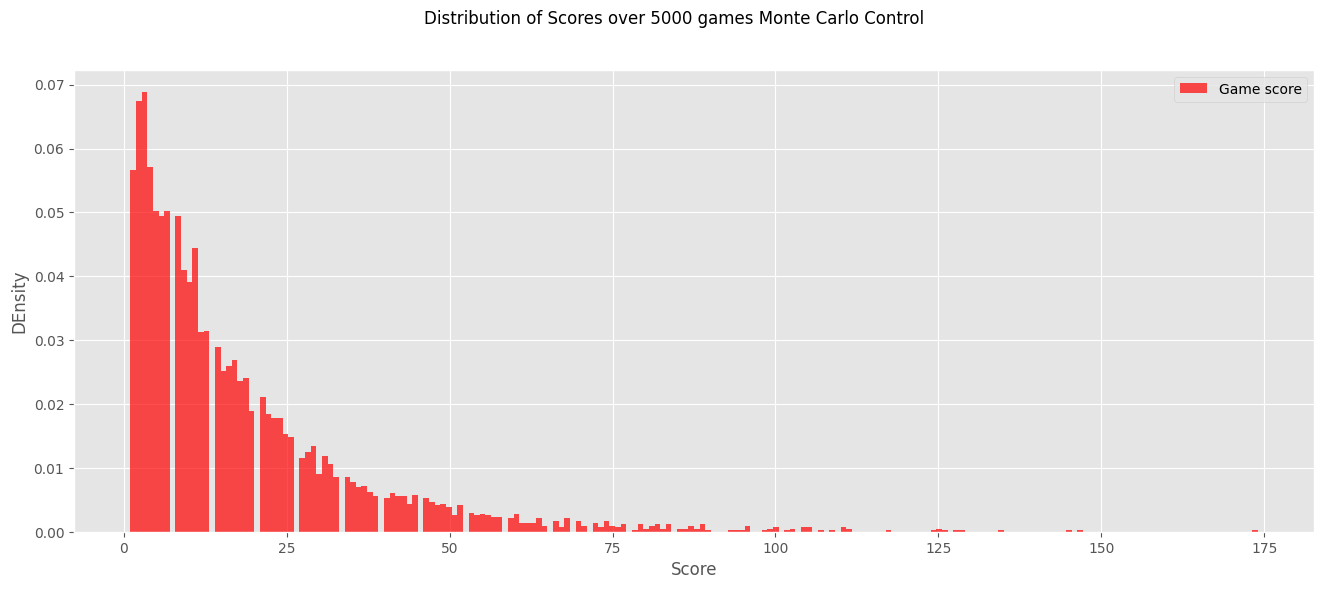

In [147]:
fig, ax = plt.subplots(figsize=(16,6))

fig.suptitle('Distribution of Scores over 5000 games Monte Carlo Control')
ax.hist(score_list, bins=200, color='red', alpha=0.7,label='Game score',density=True)
ax.set_xlabel('Score')
ax.set_ylabel('DEnsity')
ax.legend()

plt.show()

### SARSA($\lambda$) agent
In this section we are going to transform the provided ExpectedSarsaAgent in lab4 into a SarsaLambdaAgent while maintaining the same structure, we need to make several key changes. The Sarsa(λ) algorithm introduces eligibility traces, which require updating not just the current state-action pair but also potentially all previously visited state-action pairs in the episode. This change fundamentally affects how the agent updates its action-value estimates.

The update for Sarsa($\lambda$) at each time step involves computing the temporal difference (TD) error, updating the eligibility traces, and then updating the action-value function. The TD error $\delta_t$ at time $t$ is given by:

$$
\delta_t = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)
$$

Where:

- $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$ and transitioning to state $S_{t+1}$,
- $\gamma$ is the discount factor,
- $Q(S_t, A_t)$ is the current estimate of the action-value function for the state-action pair $(S_t, A_t)$,
- $Q(S_{t+1}, A_{t+1})$ is the estimate for the next state-action pair.

The eligibility trace for each state-action pair $(s, a)$ at time $t$ is updated as follows:

$$
E_t(s, a) = \gamma \lambda E_{t-1}(s, a) + 1_{(S_t = s, A_t = a)}
$$

Here, $1_{(S_t = s, A_t = a)}$ is an indicator function that is 1 if the current state-action pair matches $(s, a)$ and 0 otherwise. $\lambda$ is the trace-decay parameter.

Finally, the action-value function $Q$ for all state-action pairs is updated using the TD error and the eligibility traces:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \delta_t E_t(s, a)
$$

Where:

- $\alpha$ is the step-size parameter.

This update rule applies at every time step within an episode, and upon reaching a terminal state, ensuring that credit is appropriately distributed among state-action pairs that preceded the current one, weighted by their eligibility traces.


In [191]:
class SarsaLambdaAgent():
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts."""
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.state_map = agent_init_info["state_map"] ## the mapping for states
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.lambda_ = agent_init_info["lambda"]  # Lambda parameter for eligibility traces
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Initialize action-value estimates and eligibility traces
        self.q = np.zeros((self.num_states, self.num_actions))
        self.e = np.zeros((self.num_states, self.num_actions))  # Eligibility traces

    def agent_start(self, state):
        """Starts the agent by initializing state and selecting an action."""
        action = self._choose_action(state)
        self.prev_state = state
        self.prev_action = action
        self.e *= 0  # Reset eligibility traces
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent."""
        action = self._choose_action(state)
        # Update eligibility trace
        self.e *= self.lambda_ * self.discount
        self.e[self.state_map[self.prev_state], self.prev_action] += 1
        
        # TD error
        td_error = reward + self.discount * self.q[self.state_map[state], action] - self.q[self.state_map[self.prev_state], self.prev_action]
        # Update Q
        self.q += self.step_size * td_error * self.e
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Final update when the episode ends."""
        td_error = reward - self.q[self.state_map[self.prev_state], self.prev_action]
        self.e[self.state_map[self.prev_state], self.prev_action] += 1  # Ensure eligibility for the last action
        self.q[self.state_map[self.prev_state], self.prev_action] += self.step_size * td_error   # Update Q based on the last action taken
    
    def _choose_action(self, state):
        """Choose an action based on epsilon-greedy policy."""
        if self.rand_generator.rand() < self.epsilon:
            return self.rand_generator.randint(self.num_actions)
        else:
            return self.argmax(self.q[self.state_map[state], :])
    
    def argmax(self, q_values):
        """argmax with random tie-breaking"""
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)


In [192]:
height = 15 
width = 20
pipe_gap = 4
screen_size=(width,height)
x_dist_max = screen_size[0]-int(screen_size[0]*0.3)-1
x_dist_min = 0
y_dist_max = screen_size[1]-1-int(pipe_gap //2)-1
y_dist_min = -y_dist_max

all_states = [(x, y) for x in range(x_dist_min,x_dist_max+1) for y in range(y_dist_min-1,y_dist_max+1)]
# Create a dictionary to map (x, y) states to unique indices.
state_map = {state: index for index, state in enumerate(all_states)}


##### Train SARSA ($\lambda$)

In [171]:
num_episodes =100000 # The number of episodes in each run
env_info = {}
agent_info = {"num_actions": 2, "num_states": len(state_map), "state_map": state_map,"epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0,"lambda":0.6}
env = gym.make('TextFlappyBird-v0', height=height, width = width, pipe_gap = pipe_gap)
agent = SarsaLambdaAgent()
agent.agent_init(agent_info)
for episode in range(1,num_episodes+1):
    print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
    obs,info = env.reset()
    agent.agent_start(obs)
    while True: 
        obs, reward, done, _, info = env.step(agent.prev_action)
        if done:
            agent.agent_end(reward)
            break
        else:
            agent.agent_step(reward,obs)

Episode 279/100000.

Episode 100000/100000.

In [172]:
state_q_value=agent.q.sum(axis=1)
q_values_dict = {}
# Populate the dictionary
for (x, y), index in state_map.items():
    # Assign the Q-value corresponding to the action of interest
    q_value_for_action = state_q_value[index]  # Change 0 to the action of interest
    q_values_dict[(x, y)] = q_value_for_action

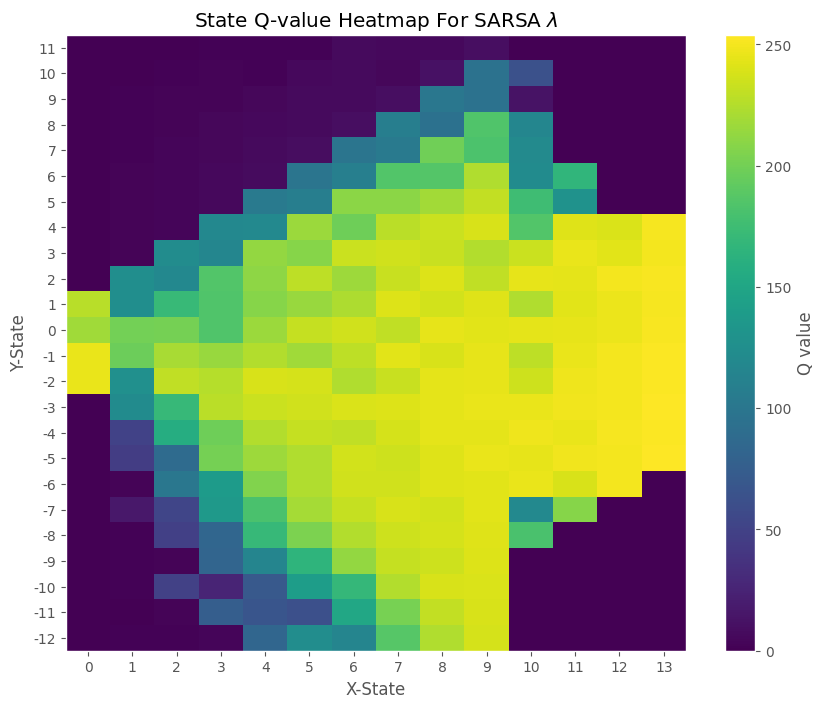

In [173]:
state_x = [key[0] for key in q_values_dict.keys()]
state_y = [key[1] for key in q_values_dict.keys()]
q_values = [val for val in q_values_dict.values()]

# Find the range for the states to set up the axes of the heatmap
max_x = max(state_x)
min_x = min(state_x)
max_y = max(state_y)
min_y = min(state_y)

# Set up the grid for the heatmap
grid_x, grid_y = np.meshgrid(range(min_x, max_x + 1), range(min_y, max_y + 1))

# Initialize a grid for Q values
q_value_grid = np.full(grid_x.shape, np.nan)

# Populate the grid with Q values
for x, y, q in zip(state_x, state_y, q_values):
    q_value_grid[y - min_y, x - min_x] = q  # Notice the reversal of indices to match the meshgrid

# Plotting the heatmap
plt.figure(figsize=(10, 8))
c = plt.pcolormesh(grid_x, grid_y, q_value_grid, cmap='viridis', shading='auto')
plt.colorbar(c, label='Q value')

# Set the ticks for the states
plt.xticks(ticks=np.arange(min_x, max_x+1), labels=np.arange(min_x, max_x+1))
plt.yticks(ticks=np.arange(min_y, max_y+1), labels=np.arange(min_y, max_y+1))

plt.xlabel('X-State')
plt.ylabel('Y-State')
plt.title(r'State Q-value Heatmap For SARSA $\lambda$')
plt.show()


Let's play with SARSA($\lambda$)

In [ ]:
obs,info = env.reset()
while True: 
    action = np.argmax(agent.q[state_map[obs],:])
    obs, reward, done, _, info = env.step(action)
    # Render the game
    clear_output(wait=True)
    sys.stdout.write(env.render())
    time.sleep(0.4) # FPS
    # If player is dead break
    if done:
        break
   
    

### Test performance

Notably, due to SARSA(λ) algorithm's impressive performance, simulating the game for 5000 trials could be excessively time-consuming, as the agent consistently demonstrates prolonged gameplay before failing. To make the evaluation process more efficient, it is advisable to implement a maximum score cutoff. For example, setting the score limit to 1000 would terminate a trial once this score is reached, thereby expediting the overall assessment period without compromising the integrity of the performance evaluation.

In [182]:
env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)
num_episodes = 5000
score_list = []
for episode in range(num_episodes):
    obs,info=env.reset()
    while True: 
        action = np.argmax(agent.q[state_map[obs],:])
        obs, reward, done, _, info = env.step(action)
        # If player is dead break
        if done or info['score']>=1000:
            break
   
            
    score_list.append(info['score'])
    

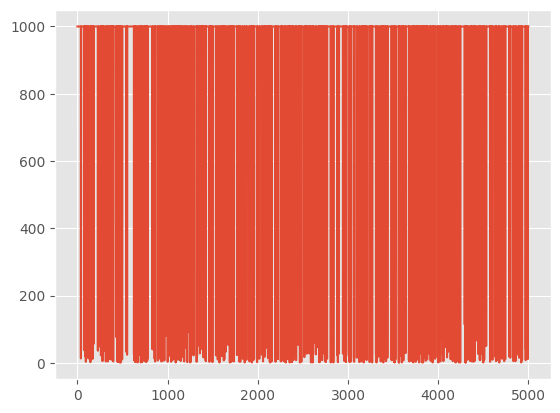

In [183]:
plt.plot([i for i in range(5000)],score_list)

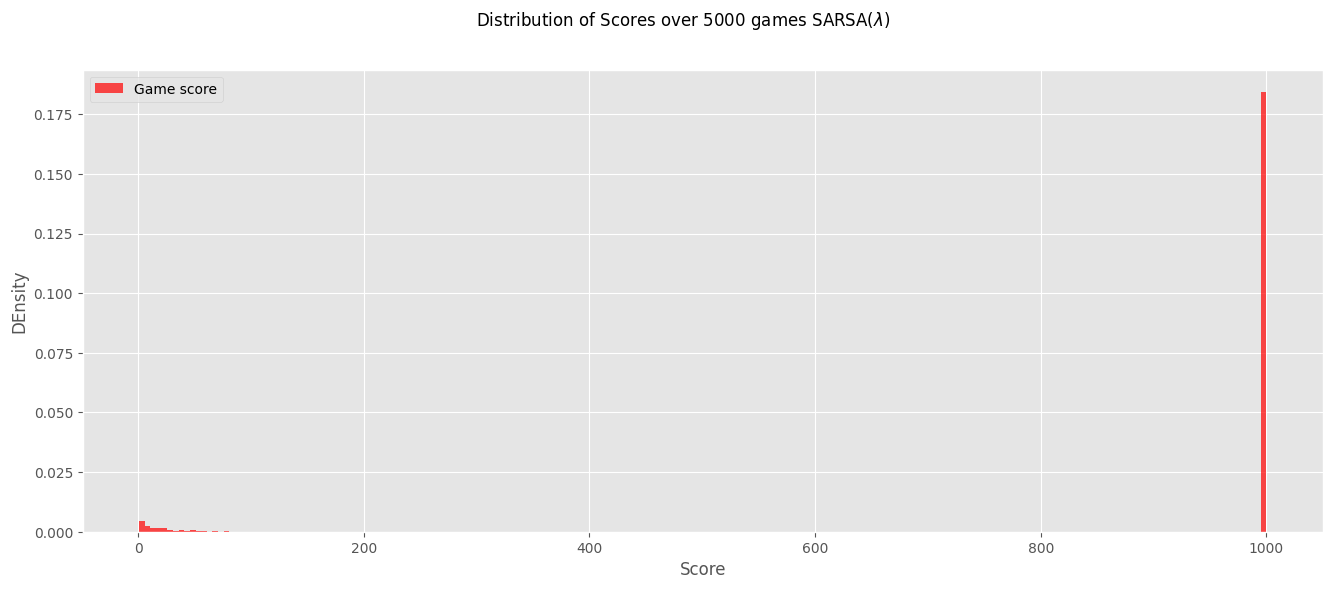

In [184]:
fig, ax = plt.subplots(figsize=(16,6))

fig.suptitle(r'Distribution of Scores over 5000 games SARSA($\lambda$)')
ax.hist(score_list, bins=200, color='red', alpha=0.7,label='Game score',density=True)
ax.set_xlabel('Score')
ax.set_ylabel('DEnsity')
ax.legend()

plt.show()

In [190]:
prob=np.mean([i==1000 for i in score_list])
print(f'Probalilty for SARSA agent to achieve Maximum score={round(prob*100,2)}%')

Probalilty for SARSA agent to achieve Maximum score=92.14%


#### Conclusison:
The SARSA(λ) algorithm exhibits exceptional proficiency in mastering the game of Flappy Bird, outperforming the Monte Carlo control approach. It is not uncommon for a single game played by the SARSA(λ) agent to continue indefinitely without reaching a terminal state, necessitating the imposition of a maximum score threshold to ensure timely completion of trials. When subjected to 5000 game trials, the agent consistently achieves high scores with a success rate of 92%, underscoring its robust performance.

In contrast, the Monte Carlo approach, despite undergoing extensive training across 500,000 episodes, does not demonstrate the same level of success and tends to yield lower scores. Therefore, it does not require a maximum score limit for game termination, indicating that there is still room for improvement in its strategy and overall performance.